In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.preprocessing import QuantileTransformer

First, we read in the dataframe.

In [2]:
df = pd.read_csv('./data/Life Expectancy Data.csv')
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Now we will create a baseline model for (i). 

This model will just be done without any analysis of the data, we will see what we can get by just training a linear regression on the data. 

But before we create this model, we will transform the features into the proper data types necessary for linear regressions, and then fill in na values to ensure we get proper model specifications.

So first we observe that the datatypes are all numerical except for Country and Status. We can use feature engineering later to get these numerical features more refined, but for now they are fine. As for the Country and Status features, we will use label encoding for Country because there are 183 unique countries, and one-hot-encoding for Status because it is just Developing or Developed.

In [3]:
# Label Encoding for Country
country_le = LabelEncoder()
country_le.fit(df['Country'].unique())
df['Country'] = country_le.transform(df['Country'])
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,0,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,0,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,0,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,0,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,0,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Now there are many Na values throughout the dataset, including in our Life expectancy variable.

So first, we will drop all rows where Life expectancy is missing because these are useless.

Now, I would like to simply average out the values for each missing feature by country. Unfortunately, some of these features are missing for entire countries. So, instead we will group by Status.

Note: this is why I'm doing one-hot-encoding of Status last, so I can get proper averages based on this before I do so.

In [4]:
before = df['Life expectancy '].isna().sum()
df.dropna(subset=['Life expectancy '], inplace=True)
print(f"For Life expectancy: {before} -> {df['Life expectancy '].isna().sum()}")

for column in df:
    if df[column].isna().sum() > 0 and column != 'Status':
        before = df[column].isna().sum()
        df[column] = df.groupby('Status')[column].apply(lambda x: x.fillna(x.mean()))
        print(f'For {column}: {before} -> {df[column].isna().sum()}')

For Life expectancy: 10 -> 0
For Alcohol: 193 -> 0
For Hepatitis B: 553 -> 0
For  BMI : 32 -> 0
For Polio: 19 -> 0
For Total expenditure: 226 -> 0
For Diphtheria : 19 -> 0
For GDP: 443 -> 0
For Population: 644 -> 0
For  thinness  1-19 years: 32 -> 0
For  thinness 5-9 years: 32 -> 0
For Income composition of resources: 160 -> 0
For Schooling: 160 -> 0


And so finally, we get dummy variables for Status.

In [5]:
df = pd.get_dummies(df, columns=['Status'])
df.head()

,Country,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developed,Status_Developing
0,0,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,...,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,0,1
1,0,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,...,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,0,1
2,0,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,...,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,0,1
3,0,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,...,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,0,1
4,0,2011,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,...,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,0,1


Now we are ready to train our first baseline linear regression model.

In [6]:
mean_squared_error([0,1,2,3], [4,5,6,7])

16.0

In [7]:
# Our regression training definitions for ease of regression testing

def regression_test_sklearn(X, y, output_model=False):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

    model = LinearRegression()

    model.fit(x_train, y_train)

    test_score = model.score(x_test, y_test)
    print('R^2 Score:', test_score)

    y_pred = model.predict(x_test)
    print('MSE:', mean_squared_error(y_test, y_pred))
    
    if output_model:
        return model
    
def regression_test_sm(X, y, output_model=False):
    # Fit the WLS linear regression model
    X = sm.add_constant(X)
    y = np.array(y)
    model = sm.OLS(y, X).fit()

    # Print the p-values of the coefficients
    print(model.summary())
    print('F-statistic:', model.fvalue)
    print('p-value:', model.f_pvalue)

def regression_test_residual_graph(X, y, model):
    y_pred = model.predict(X=X)
    residuals = (y - y_pred)
    RMSE = residuals.std() # Root Mean Square Error
    R2_square = model.score(X=X, y=y) # coefficient of determination R^2
    #print(f"R^2: {R2_square}\nRMSE: {RMSE}")

    residuals_1d = []
    for i in residuals:
        residuals_1d.append(i[0])
    # distribution of the residuals.
    plt.rcParams["figure.figsize"] = [7, 2]
    plt.rcParams["figure.autolayout"] = True
    sns.kdeplot(x=np.array(residuals_1d), fill=True, alpha=0.2);
    sns.histplot(x=np.array(residuals_1d), fill=True, alpha=0.2, stat='density');
    sns.kdeplot(x=np.random.normal(scale=np.std((residuals_1d)), size=100000), fill=True, alpha=0.2, color='purple');

R^2 Score: 0.798589966690018
MSE: 17.30010291058671


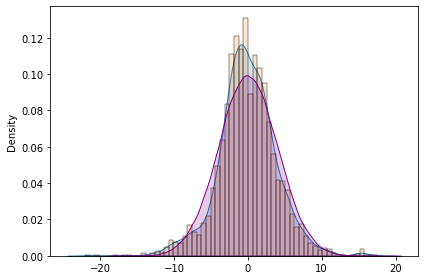

In [8]:
X = np.array(df.loc[:, np.array(df.drop('Life expectancy ', axis=1).columns)])
y = np.array(df.loc[:, ['Life expectancy ']])
regression_test_residual_graph(X,y,regression_test_sklearn(X,y,output_model=True))

Our R2 value is 0.79 right off the bat. Also the residuals very nearly match that of a normal distribution. Our MSE is 17.3, which implies that we are within 4 years for the average guess. So, it looks like we already have a pretty good model!

So now, before we move forward, I would like to train our model based on the statsmodel api package in order to get some more statistics on our baseline model.

In [9]:
regression_test_sm(X,y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     648.3
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:20:07   Log-Likelihood:                -8209.2
No. Observations:                2928   AIC:                         1.646e+04
Df Residuals:                    2906   BIC:                         1.659e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.1756     22.984      2.357      0.0

Our main takeaways here are: 
- Several of our coefficients are not statistically significant
- Our condition number is extremely high, meaning that a lot of the data is highly correlated

In order to try and reduce our large Condition Number, we will try to use PCA by itself, as instructed for the model for part (ii). It will be interesting to see just how well it reduces our Condition Number and maintains a good R^2.

R^2 Score: 0.6830114741153424
MSE: 27.227710701182684
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     595.6
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:20:07   Log-Likelihood:                -9029.2
No. Observations:                2928   AIC:                         1.808e+04
Df Residuals:                    2916   BIC:                         1.815e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

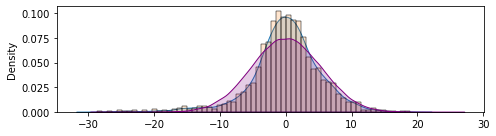

In [10]:
# Regular sklearn
pca = PCA(n_components=11)
X = np.array(df.loc[:, np.array(df.drop('Life expectancy ', axis=1).columns)])
X = pca.fit_transform(X)
regression_test_residual_graph(X,y,regression_test_sklearn(X,y,output_model=True))
regression_test_sm(X, y)

So, you can see even training at 11 components, our model has lost a lot of its accuracy, and our condition number is still at 53,900,000. So although the condition number is technically going down, the multicollinearity is still way too high to be acceptable.

So, we will move on to our modeling for part (iii) in which we will start looking into the data and make decisions about our model.

We are trying to predict on Life Expectancy, so first we will take a general view into what exactly are the most correlated variables to this feature.

In [11]:
df.corr()['Life expectancy ']

Country                           -0.016763
Year                               0.170033
Life expectancy                    1.000000
Adult Mortality                   -0.696359
infant deaths                     -0.196557
Alcohol                            0.404881
percentage expenditure             0.381864
Hepatitis B                        0.231823
Measles                           -0.157586
 BMI                               0.564304
under-five deaths                 -0.222529
Polio                              0.463225
Total expenditure                  0.219833
Diphtheria                         0.477065
 HIV/AIDS                         -0.556556
GDP                                0.451944
Population                        -0.023008
 thinness  1-19 years             -0.474954
 thinness 5-9 years               -0.469397
Income composition of resources    0.708915
Schooling                          0.735217
Status_Developed                   0.482136
Status_Developing               

I will choose a bunch of the variables and slowly widdle them down over the process of refining this model.

First, let's see how a model would perform solely based on the variables of: Schooling, Income Comp, BMI, Adult Mortality, HIV/AIDS, GDP & Status.

R^2 Score: 0.7657465070084986
MSE: 20.121189939332226
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     1574.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:20:08   Log-Likelihood:                -8465.0
No. Observations:                2928   AIC:                         1.695e+04
Df Residuals:                    2920   BIC:                         1.699e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

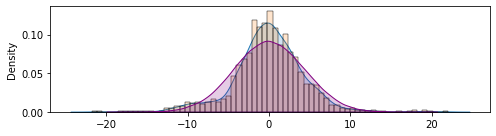

In [12]:
X = df.loc[:,['Schooling','Income composition of resources',' BMI ','Adult Mortality',' HIV/AIDS','Status_Developed', 'Status_Developing','GDP']]
regression_test_residual_graph(X,y,regression_test_sklearn(X,y,output_model=True))
regression_test_sm(X, y)

Here are our takeaways from this initial model:
- Our R2 number is still good, but underperforms our baseline in R2 and in MSE
- We still have crazy high multicollinearity
- All the variables are now statistically significant, as some in the baseline model were not

A lot of our features aren't normally distributed which is sometimes an issue. So, we will see if using a quantile transformer will provide us with better model performance. This will also help get rid of outliers which might be affecting our data.

In [13]:
print('Initial Model')
X = df.loc[:,['Schooling','Income composition of resources',' BMI ','Adult Mortality',' HIV/AIDS','Status_Developed', 'Status_Developing','GDP']]
regression_test_sklearn(X, y)

qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
input_arr = ['Schooling','Income composition of resources',' BMI ','Adult Mortality',' HIV/AIDS','Status_Developed', 'Status_Developing','GDP']
for i in range(len(input_arr)):
    print(f'Testing {input_arr[i]}')
    df[f'{input_arr[i]}_t'] = qt.fit_transform(np.array(df[input_arr[i]]).reshape(-1,1))
    new_arr = input_arr.copy()
    new_arr[i] = f'{input_arr[i]}_t'
    X = df.loc[:,new_arr]
    regression_test_sklearn(X, y)

Initial Model
R^2 Score: 0.7657465070084986
MSE: 20.121189939332226
Testing Schooling
R^2 Score: 0.7543223293013155
MSE: 21.102469008478298
Testing Income composition of resources
R^2 Score: 0.7569515444506284
MSE: 20.876632728578663
Testing  BMI 
R^2 Score: 0.7619699867928917
MSE: 20.445573920111162
Testing Adult Mortality
R^2 Score: 0.745336334625559
MSE: 21.874320490203193
Testing  HIV/AIDS
R^2 Score: 0.7770186353113758
MSE: 19.152971144784964
Testing Status_Developed
R^2 Score: 0.7657465070084832
MSE: 20.12118993933354
Testing Status_Developing
R^2 Score: 0.7657465070084468
MSE: 20.121189939336663
Testing GDP
R^2 Score: 0.7658188690952701
MSE: 20.114974402164588


We can see that Quantile Transformation improves model performance in Income Composition, BMI, HIV, and slightly in GDP.

Now, we see results for transforming data by squaring our data.

In [14]:
print('Initial Model')
X = df.loc[:,['Schooling','Income composition of resources',' BMI ','Adult Mortality',' HIV/AIDS','Status_Developed', 'Status_Developing','GDP']]
regression_test_sklearn(X, y)

input_arr = ['Schooling','Income composition of resources',' BMI ','Adult Mortality',' HIV/AIDS','Status_Developed', 'Status_Developing','GDP']
for i in range(len(input_arr)):
    print(f'Testing {input_arr[i]}')
    df[f'{input_arr[i]}_2'] = df[input_arr[i]] ** 2
    new_arr = []
    new_arr = input_arr.copy()
    new_arr[i] = f'{input_arr[i]}_2'
    X = df.loc[:,new_arr]
    regression_test_sklearn(X, y)

Initial Model
R^2 Score: 0.7657465070084986
MSE: 20.121189939332226
Testing Schooling
R^2 Score: 0.7742834394112073
MSE: 19.38791063501733
Testing Income composition of resources
R^2 Score: 0.7889633702871918
MSE: 18.12697883980748
Testing  BMI 
R^2 Score: 0.7648326438678823
MSE: 20.19968615979867
Testing Adult Mortality
R^2 Score: 0.7695675519570403
MSE: 19.79298150924865
Testing  HIV/AIDS
R^2 Score: 0.7358895045651095
MSE: 22.685755400067244
Testing Status_Developed
R^2 Score: 0.7657465070084986
MSE: 20.121189939332226
Testing Status_Developing
R^2 Score: 0.7657465070084986
MSE: 20.121189939332226
Testing GDP
R^2 Score: 0.7638130231981959
MSE: 20.287266416975758


So, we see that the model results improve with squaring in Schooling, Income Comp, and Adult Mortality. We will keep this in mind when selecting better variables for our data in the future.

Let's see what our model looks like when we select from these transformed features:

R^2 Score: 0.8199930088338868
MSE: 15.46168987026573
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     1934.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:20:09   Log-Likelihood:                -8221.6
No. Observations:                2928   AIC:                         1.646e+04
Df Residuals:                    2920   BIC:                         1.651e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

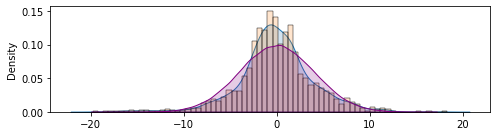

In [15]:
X = df.loc[:,['Schooling_2','Income composition of resources_2',' BMI _t','Adult Mortality_2',' HIV/AIDS_t','Status_Developed', 'Status_Developing','GDP']]
regression_test_residual_graph(X,y,regression_test_sklearn(X,y,output_model=True))
regression_test_sm(X, y)

Our initial model without any data transformation was: 

R^2 Score: 0.798589966690018
MSE: 17.30010291058671

Our model is currently better than this, but now we must get our collinearity down. So, let's check our correlation matrix and see what we can fix.

In [16]:
df.loc[:,['Life expectancy ','Schooling_2','Income composition of resources_2',' BMI _t','Adult Mortality_2',' HIV/AIDS_t','Status_Developed', 'Status_Developing','GDP_t']].corr()

,Life expectancy,Schooling_2,Income composition of resources_2,BMI _t,Adult Mortality_2,HIV/AIDS_t,Status_Developed,Status_Developing,GDP_t
Life expectancy,1.000000,0.748263,0.801058,0.513783,-0.694732,-0.741752,0.482136,-0.482136,0.551459
Schooling_2,0.748263,1.000000,0.876674,0.536064,-0.392612,-0.574309,0.603246,-0.603246,0.596659
Income composition of resources_2,0.801058,0.876674,1.000000,0.540590,-0.458329,-0.605670,0.604151,-0.604151,0.638826
BMI _t,0.513783,0.536064,0.540590,1.000000,-0.306398,-0.468629,0.313088,-0.313088,0.391312
Adult Mortality_2,-0.694732,-0.392612,-0.458329,-0.306398,1.000000,0.550364,-0.245517,0.245517,-0.290370
HIV/AIDS_t,-0.741752,-0.574309,-0.605670,-0.468629,0.550364,1.000000,-0.369516,0.369516,-0.442132
Status_Developed,0.482136,0.603246,0.604151,0.313088,-0.245517,-0.369516,1.000000,-1.000000,0.450343
Status_Developing,-0.482136,-0.603246,-0.604151,-0.313088,0.245517,0.369516,-1.000000,1.000000,-0.450343
GDP_t,0.551459,0.596659,0.638826,0.391312,-0.290370,-0.442132,0.450343,-0.450343,1.000000


So, from our correlation matrix, we see:
- Income comp is very similar to Schooling, with Income comp being a superior predictor
- HIV/AIDS is similar to BMI, with HIV being superior
- Status Developing/Developed aren't great, and we can do without them
- We can also do without GDP

R^2 Score: 0.7721013917833986
MSE: 19.57533748707883
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     3260.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:20:10   Log-Likelihood:                -8602.9
No. Observations:                2928   AIC:                         1.721e+04
Df Residuals:                    2924   BIC:                         1.724e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

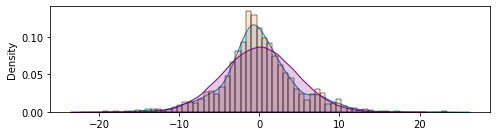

In [17]:
X = df.loc[:,['Income composition of resources_2', 'Adult Mortality_t', ' HIV/AIDS_t']]
X = np.array(X)
regression_test_residual_graph(X,y,regression_test_sklearn(X,y,output_model=True))
regression_test_sm(X, y)

Using the Adult Mortality quantile transformation gets us to our desired Condition Number, but it decreases our model's effectiveness to below that of our baseline. So now, we will try to maintain our good Condition Number, but try our best to increase our model's effectiveness. To do this, we will now try to engineer new features:

In [18]:
df['infant_illness'] = df['infant deaths'] * df['under-five deaths '] * df[' thinness  1-19 years'] * df[' thinness 5-9 years']
df['infant_illness_t'] = qt.fit_transform(np.array(df['infant_illness']).reshape(-1,1))

df['disease'] = df['Alcohol'] * df['Hepatitis B'] * df['Measles '] * df[' BMI _2'] * df['Polio'] * df['Diphtheria ']
df['disease_t'] = qt.fit_transform(np.array(df['disease']).reshape(-1,1))

R^2 Score: 0.7926061753214447
MSE: 17.814080316630204
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     2113.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:20:21   Log-Likelihood:                -8513.9
No. Observations:                2928   AIC:                         1.704e+04
Df Residuals:                    2922   BIC:                         1.708e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

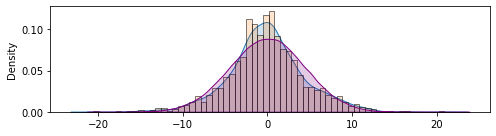

In [20]:
X = df.loc[:,['Income composition of resources_2','disease_t',' HIV/AIDS_t', 'Adult Mortality_t','infant_illness_t']]
X = np.array(X)
regression_test_residual_graph(X,y,regression_test_sklearn(X,y,output_model=True))
regression_test_sm(X, y)

So with this model I conclude my research. Through my efforts I was able to significantly decrease the multicollinearity within the baseline model, and I maintained the strong predictive power of the baseline model. 